# Parser

In [2]:
story_file = 'story.txt'
text_file = open("scene_text.txt", "w")

lines = [line.rstrip('\n') for line in open(story_file)]
scenes = ['yard','desert','castle','volcano','lagoon','garden'] # can add more
birds = ['David','Wendy','Alex','Ben']
features = ['This bird has a bright yellow body, with brown on its crown and wings.',
            'This colorful bird has a bright yellow body, a black crown and tail.',
            'This white bird has a black crown and yellow beak.',
            'This blue bird has a blue crown and black tails.']

scenes_to_generate = []
birds_to_generate = []
for i in range(len(lines)):
    content = lines[i].split('.')
    scene_candidate = content[0].split(' ')
    scenes_to_generate.append( [w for w in scene_candidate if w in scenes][0] )
    
    temp_birds = []
    for j in range(len(content)-2): #first sentence and last space
        birds_candidate = content[j+1].split(' ') 
        temp_birds.append( [w for w in birds_candidate if w in birds][0])
    birds_to_generate.append(temp_birds)

for i in range(len(lines)):
    print scenes_to_generate[i], birds_to_generate[i]

for i in range(len(lines)):
    for j in range(len(birds_to_generate[i])):
        for k in range(len(birds)):
            if birds_to_generate[i][j] == birds[k]:
                text_file.write("%s\n" % features[k])
text_file.close()

yard ['David']
desert ['David', 'Alex']
castle ['David', 'Ben']
volcano ['David']
lagoon ['David', 'Wendy']
garden ['David', 'Wendy']


In [2]:
print scenes_to_generate

['yard', 'desert', 'castle', 'volcano', 'lagoon', 'garden']


# StackGAN

In [4]:
import tensorflow as tf 

# Segmentation

In [5]:
import os, sys
import glob
os.chdir("PSPNet")

from mask import mask
import cv2
import numpy as np


def norm0255(arr):
    '''Maps the input range to [0,255] as dtype uint8'''
    arr = arr.copy()
    arr -= arr.min()
    arr *= 255.0 / (arr.max() + 1e-10)
    arr = np.array(arr, 'uint8')
    return arr

basic_path = "../Result/"
for img_path in glob.glob(basic_path + "chracters/*.jpg"):
    img_name = img_path.split("/")[-1]
    bird_name = img_name.split(".")[0]
    
    mask_img = mask(img_path) 
    mask_img_temp = norm0255(mask_img)
    ret, threshold = cv2.threshold(mask_img_temp, 0, 255,
        cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    connectivity = 8
    out_of_ccpn = cv2.connectedComponentsWithStats(threshold, connectivity, cv2.CV_32S)
    num_labels = out_of_ccpn[0]
    labels_matrix = out_of_ccpn[1]
    stats = out_of_ccpn[2]

    index_max = np.argmax(stats[1:,4])
    select_max = labels_matrix == (index_max + 1)
    
    cv2.imwrite(basic_path + "chracters_mask/" + img_name, (mask_img * select_max))
    print bird_name
os.chdir("../")

/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:97: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Alex
Wendy
David
Ben


# Scene

In [6]:
import os, sys
os.environ['GLOG_minloglevel'] = '2'    # suprress Caffe verbose prints
os.chdir("PPGN")

import caffe
import numpy as np
from numpy.linalg import norm
import scipy.misc, scipy.io
import argparse 
import util
import settings
from sampler import Sampler
from sampling_class import ClassConditionalSampler
from sampling_class import get_code
import settings
from conditional_sampling_from_real_image import conditional_sampling_from_real_image

label_to_name = {"8":"amusement_park.jpg",
                 "10":"aqueduct.jpg",
                 "12":"arch.jpg",
                 "84":"castle.jpg",
                 "91":"church.jpg",
                 "94":"cliff.jpg",
                 "117":"desert.jpg",
                 "204":"lagoon.jpg",
                 "209":"lawn.jpg",
                 "229":"water.jpg",
                 "230":"outdoor.jpg",
                 "232":"mountain.jpg",
                 "234":"mountain_snowy.jpg",
                 "350":"volcano.jpg",
                 "362":"yard.jpg",
                 "364":"garden.jpg"}

name_to_label = {"amusement_park":"8",
                 "aqueduct":"10",
                 "arch":"12",
                 "castle":"84",
                 "church":"91",
                 "cliff":"94",
                 "desert":"117",
                 "lagoon":"204",
                 "lawn":"209",
                 "water":"229",
                 "outdoor":"230",
                 "mountain":"232",
                 "mountain_snowy":"234",
                 "volcano":"350",
                 "yard":"362",
                 "garden":"364"}
    
opt_layer="fc6"
act_layer="fc8"
xy=0              # Spatial position for conv layers, for fc layers: xy = 0

n_iters=100       # Run for N iterations
reset_every=0     # Reset the code every N iterations (for diversity)
save_every=5      # Save a sample every N iterations
lr=0.5 
lr_end=0.5        # Linearly decay toward this ending lr (e.g. for decaying toward 0, set lr_end = 1e-10)
threshold=0.      # Filter out samples below this threshold e.g. 0.98
seed=0

# -----------------------------------------------
# Multipliers in the update rule Eq.11 in the paper
# -----------------------------------------------
epsilon1=1e-5     # prior
epsilon2=1.       # condition
epsilon3=1e-17    # noise
epsilon4=0.
# -----------------------------------------------

# Condition net
net_weights="nets/placesCNN/alexnet_places365.caffemodel"
net_definition="nets/placesCNN/deploy_alexnet_places365.prototxt"

# Default to constant learning rate
if lr_end < 0:
    lr_end = lr

encoder_definition = settings.encoder_definition
encoder_weights = settings.encoder_weights
generator_definition = settings.generator_definition
generator_weights = settings.generator_weights

scenes_to_generate = ['yard', 'desert', 'castle', 'volcano', 'lagoon', 'garden']
img_list = []
for scene in scenes_to_generate:
    
    # Index of neurons in fc layers or channels in conv layers
    # from 0 to 364
    units = name_to_label[scene]

    if units in label_to_name:
        img_name = label_to_name[units]
    else:
        img_name = "defalut.jpg"
    # Start from a random code. To start from a real code, replace with a path e.g. "images/filename.jpg"
    init_file="images/" + img_name
    output_dir=("output/" + act_layer + "_chain_" + units + "_eps1_" + 
            str(epsilon1) + "_eps3_" + str(epsilon3))
    
    output_image, _ = conditional_sampling_from_real_image(encoder_definition, encoder_weights,
                         generator_definition, generator_weights,
                         net_definition, net_weights,
                         units, xy,
                         n_iters,
                         reset_every,
                         save_every,
                         threshold,
                         epsilon1, epsilon2, epsilon3, epsilon4,
                         lr, lr_end,
                         seed,
                         opt_layer,
                         act_layer,
                         init_file,
                         output_dir)



    filename = '../Result/scene/' + scene + ".jpg"
    util.save_image(output_image, filename)
    img = output_image[:,::-1, :, :] # Convert from BGR to RGB
    img = util.deprocess(img, in_range=(-120,120))
    img_list.append(img)
os.chdir("../")

Loaded init code:  (1, 4096)
step: 0000	 max:  362 [0.23]	 obj:  362 [0.23]	 norm: [0.54]
step: 0001	 max:  362 [0.73]	 obj:  362 [0.73]	 norm: [0.23]
step: 0002	 max:  362 [0.76]	 obj:  362 [0.76]	 norm: [0.21]
step: 0003	 max:  362 [0.84]	 obj:  362 [0.84]	 norm: [0.09]
step: 0004	 max:  362 [0.96]	 obj:  362 [0.96]	 norm: [0.03]
step: 0005	 max:  362 [0.98]	 obj:  362 [0.98]	 norm: [0.01]
step: 0006	 max:  362 [0.97]	 obj:  362 [0.97]	 norm: [0.02]
step: 0007	 max:  362 [0.99]	 obj:  362 [0.99]	 norm: [0.00]
step: 0008	 max:  362 [0.98]	 obj:  362 [0.98]	 norm: [0.01]
step: 0009	 max:  362 [0.99]	 obj:  362 [0.99]	 norm: [0.00]
step: 0010	 max:  362 [0.99]	 obj:  362 [0.99]	 norm: [0.01]
step: 0011	 max:  362 [0.98]	 obj:  362 [0.98]	 norm: [0.01]
step: 0012	 max:  362 [0.98]	 obj:  362 [0.98]	 norm: [0.01]
step: 0013	 max:  362 [0.99]	 obj:  362 [0.99]	 norm: [0.01]
step: 0014	 max:  362 [0.99]	 obj:  362 [0.99]	 norm: [0.00]
step: 0015	 max:  362 [0.99]	 obj:  362 [0.99]	 norm: [0

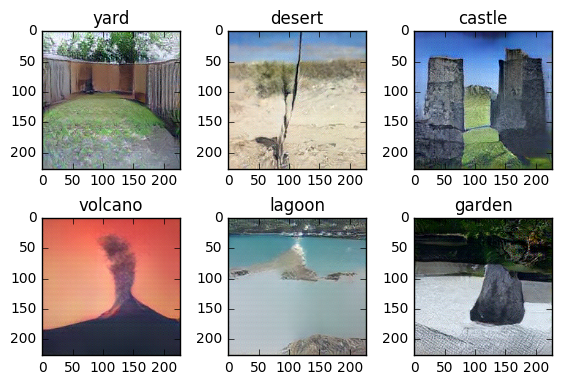

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

plt.subplot(231)
plt.imshow(img_list[0])
plt.title(scenes_to_generate[0])

plt.subplot(232)
plt.imshow(img_list[1])
plt.title(scenes_to_generate[1])

plt.subplot(233)
plt.imshow(img_list[2])
plt.title(scenes_to_generate[2])

plt.subplot(234)
plt.imshow(img_list[3])
plt.title(scenes_to_generate[3])

plt.subplot(235)
plt.imshow(img_list[4])
plt.title(scenes_to_generate[4])

plt.subplot(236)
plt.imshow(img_list[5])
plt.title(scenes_to_generate[5])

# SR

In [1]:
import os
os.chdir("SR")

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as  plt
%matplotlib inline


from sr import *

# initialization
sess, dcgan = super_resolution_initialize()
os.chdir("../")

Load model
 [*] Reading checkpoints...
DCGAN.model-3002


In [3]:
os.chdir("SR")
basic_path = "../Result/"
SR_list = []
for scene in scenes_to_generate:

    # super resolution (Can repeatly generate SR images without initialization)
    img = super_resolution(sess, dcgan, basic_path + "scene/" + scene + ".jpg")
    SR_list.append((img + 1) / 2)
# img_show = (img+1)/2  # normalize to 0~1
# plt.imshow(img_show)
os.chdir("../")

Finish!
Finish!
Finish!
Finish!
Finish!
Finish!


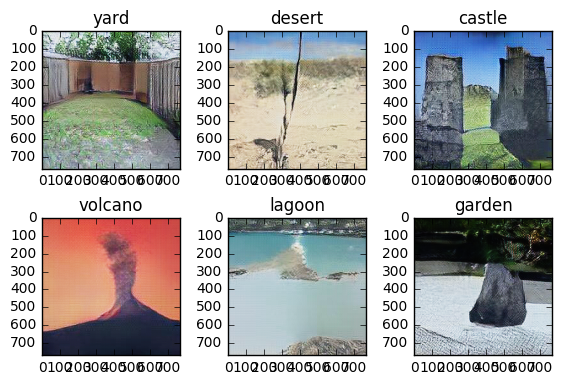

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

plt.subplot(231)
plt.imshow(SR_list[0])
plt.title(scenes_to_generate[0])

plt.subplot(232)
plt.imshow(SR_list[1])
plt.title(scenes_to_generate[1])

plt.subplot(233)
plt.imshow(SR_list[2])
plt.title(scenes_to_generate[2])

plt.subplot(234)
plt.imshow(SR_list[3])
plt.title(scenes_to_generate[3])

plt.subplot(235)
plt.imshow(SR_list[4])
plt.title(scenes_to_generate[4])

plt.subplot(236)
plt.imshow(SR_list[5])
plt.title(scenes_to_generate[5])